In [9]:
# Importing all necessary package
import os
import numpy as np
from PIL import Image

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#A generalist algorithm for cell and nucleus segmentation (v1.0) that can be optimized for your own data (v2.0)
from cellpose.models import Cellpose 
from stardist.models import StarDist2D

from csbdeep.utils import normalize

import tensorflow as tf

from tensorflow import keras
from tensorflow.config import list_physical_devices

# Setting the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check if GPU is available
if len(list_physical_devices("GPU")) >= 1:
    use_GPU = True
    tf.config.experimental.set_memory_growth(list_physical_devices("GPU")[0], True)

else:
    use_GPU = False

def load_cellpose():
    """Load the cellpose model and return it"""
    model_c = Cellpose(gpu=use_GPU, model_type="cyto2")
    return model_c


def load_stardist():
    """Load the Stardist model and return it"""
    model_s = StarDist2D.from_pretrained("2D_versatile_he")
    return model_s


def run_cellpose(image, model_cellpose, diameter=None):
    """Run the cellpose model on the image and return the mask"""
    channel = [[0, 0]]
    mask_cellpose, _, _, _ = model_cellpose.eval(
        image, batch_size=1, diameter=diameter, channels=channel
    )
    return mask_cellpose


def run_stardist(image, model_stardist, nms_thresh=0.4, prob_thresh=0.5):
    """Run the stardist model on the image and return the mask"""
    img_norm = image / 255
    img_norm = normalize(img_norm, 1, 99.8)
    mask_stardist, _ = model_stardist.predict_instances(
        img_norm, nms_thresh=nms_thresh, prob_thresh=prob_thresh
    )
    return mask_stardist

model_cellpose = load_cellpose()
model_stardist = load_stardist()

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [10]:
# Load an image, run CellPose to detect muscle fibers and Stardist to detect nuclei.
try:
    from imageio.v2 import imread
except:
    from imageio import imread

img = imread("sample_img/sample_he.jpg")

# CellPose
mask_cellpose = run_cellpose(
    img, model_cellpose)
mask_cellpose = mask_cellpose.astype(np.uint16)
cellpose_mask_filename = "results/sample_he_cellpose_mask.tiff"
Image.fromarray(mask_cellpose).save(cellpose_mask_filename)

# Stardist
mask_stardist = run_stardist(
    img, model_stardist)
mask_stardist = mask_stardist.astype(np.uint16)
stardist_filename = "results/sample_he_stardist_mask.tiff"
Image.fromarray(mask_stardist).save(stardist_filename)

1/1 [==============================] - 2s 2s/step


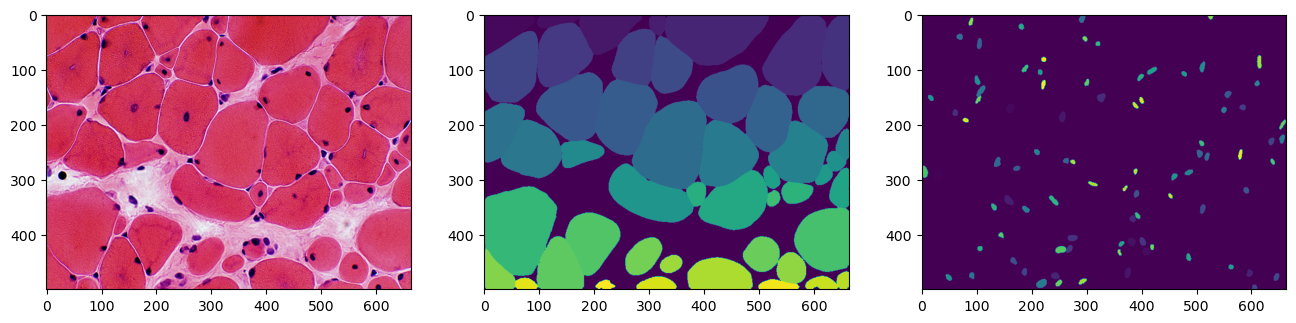

In [11]:
# Show  the raw image, the muscle fiber detected and the nuclei detected.
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
ax1.imshow(img)
ax2.imshow(mask_cellpose)
ax3.imshow(mask_stardist)
plt.show()

In [12]:
# Based on the Cellpose Image and Stardist image we will extract the coordinates of the nuclei and muscle fibers as a table. 
# We will also extract their area in pixels, perimeter, eccentrictiy....
from skimage.measure import regionprops_table
import pandas as pd
props_cellpose = regionprops_table(
    mask_cellpose,
    properties=[
        "label",
        "area",
        "centroid",
        "eccentricity",
        "bbox",
        "image",
        "perimeter",
    ],
)
df_cellpose = pd.DataFrame(props_cellpose)
df_cellpose

,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image,perimeter
0,1,4472,27.291816,35.942084,0.811990,0,0,74,92,"[[False, False, False, False, True, True, True...",288.166522
1,2,1432,10.187151,130.493715,0.959465,0,96,26,175,"[[False, False, False, False, False, False, Fa...",184.568542
2,3,5612,28.721668,222.465966,0.734992,0,173,74,288,"[[False, False, False, False, False, False, Fa...",324.592929
3,4,964,17.978216,315.574689,0.593579,0,300,40,332,"[[False, False, False, False, False, False, Fa...",118.325902
4,5,12970,37.791904,417.217579,0.850622,0,329,94,518,"[[False, False, False, False, False, False, Fa...",484.676190
5,6,11918,77.677882,570.009398,0.779154,0,506,149,623,"[[False, False, False, False, False, False, Fa...",437.102597
6,7,5628,70.467839,641.894279,0.930286,0,615,140,664,"[[False, False, False, False, False, False, Fa...",336.166522
7,8,8819,73.265109,141.965416,0.609670,15,96,134,199,"[[False, False, False, False, False, False, Fa...",368.019336
8,9,6269,79.019461,275.208646,0.715238,27,232,130,312,"[[False, False, False, False, False, False, Fa...",314.208153
9,10,9847,99.798314,50.879151,0.730104,31,0,161,99,"[[False, False, False, False, False, False, Fa...",391.320851


In [13]:
props_stardist = regionprops_table(
    mask_stardist,
    properties=[
        "label",
        "area",
        "centroid",
        "eccentricity",
        "bbox",
        "image",
        "perimeter",
    ],
)
df_stardist = pd.DataFrame(props_stardist)
df_stardist

,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image,perimeter
0,1,239,293.246862,29.029289,0.289720,285,21,303,38,"[[False, False, False, False, False, False, Tr...",55.455844
1,2,212,170.660377,160.240566,0.661954,162,153,181,169,"[[False, False, False, False, False, False, Fa...",53.698485
2,3,161,431.080745,407.900621,0.418877,424,401,439,416,"[[False, False, False, False, False, False, Fa...",46.041631
3,4,170,413.500000,381.117647,0.529735,407,374,422,389,"[[False, False, False, True, True, True, True,...",46.627417
4,5,172,470.063953,373.889535,0.825598,461,368,480,381,"[[False, False, False, False, False, False, Fa...",50.041631
...,...,...,...,...,...,...,...,...,...,...,...
83,84,77,156.571429,398.961039,0.813768,151,395,163,404,"[[False, True, True, True, True, False, False,...",32.142136
84,85,70,192.585714,79.128571,0.743460,189,74,197,85,"[[False, False, True, True, True, True, True, ...",28.727922
85,86,68,82.176471,221.044118,0.279105,78,217,87,226,"[[False, False, False, True, True, True, False...",27.899495
86,87,108,254.879630,578.648148,0.936314,246,575,265,583,"[[False, False, False, False, True, True, True...",43.556349


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage import exposure

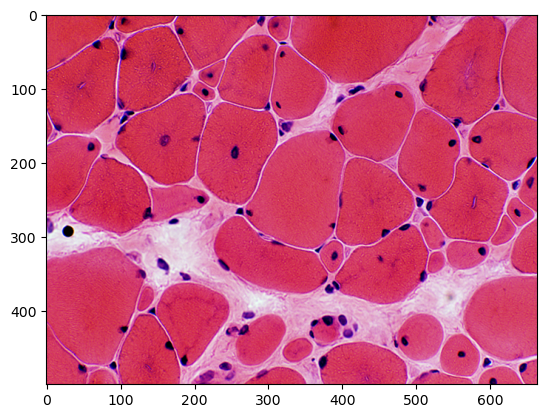

In [4]:
img = io.imread("sample_img/sample_he.jpg")
plt.figure()
plt.imshow(img)
plt.show()

In [30]:
pip install imea

Note: you may need to restart the kernel to use updated packages.


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, transform

from imea import measure_2d, tools


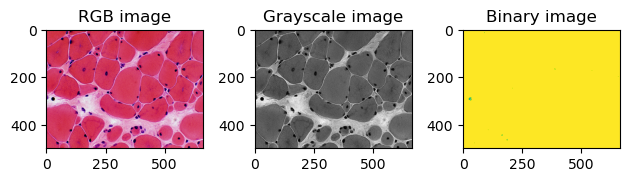

In [39]:


# segment with thresholding
threshold = 0.000003 # you may adjust here depending on the actual image
img_g=rgb2gray(img)
bw_org = img_g > threshold
fig, axarr = plt.subplots(1,3)
axarr[0].imshow(img)
axarr[0].set_title("RGB image")
axarr[1].imshow(img_g, cmap='gray')
axarr[1].set_title("Grayscale image")
axarr[2].imshow(bw_org)
axarr[2].set_title("Binary image")
plt.tight_layout()
plt.show()

In [5]:
img.shape
#Dimension de l'image pixel hauteur Y =550, Pixel largeur X =664
#PPP=DPI=72 pixel/pouce


(500, 664, 3)

In [6]:
#conversion pixel en cm 
nbr_pix= 500*664
dpi= 72
nbr_cm=2.54*((nbr_pix)/(dpi))
print(nbr_cm)

11712.222222222223


In [15]:
df_cellpose.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   label         48 non-null     int64  
 1   area          48 non-null     int64  
 2   centroid-0    48 non-null     float64
 3   centroid-1    48 non-null     float64
 4   eccentricity  48 non-null     float64
 5   bbox-0        48 non-null     int64  
 6   bbox-1        48 non-null     int64  
 7   bbox-2        48 non-null     int64  
 8   bbox-3        48 non-null     int64  
 9   image         48 non-null     object 
 10  perimeter     48 non-null     float64
dtypes: float64(4), int64(6), object(1)
memory usage: 4.2+ KB


In [19]:
df_cellpose.describe()

,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,perimeter
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,24.50,5428.770833,278.358890,368.262238,0.701052,238.062500,328.875000,318.791667,409.625000,271.059231
std,14.00,4359.640163,158.324655,206.169305,0.180776,166.830199,210.788754,149.243049,199.705914,123.274746
min,1.00,428.000000,10.187151,22.347662,0.242454,0.000000,0.000000,26.000000,58.000000,88.183766
25%,12.75,1190.250000,162.540599,190.728172,0.593557,102.500000,146.000000,218.750000,234.000000,160.485804
50%,24.50,5599.000000,280.457742,364.818827,0.732548,260.500000,324.500000,316.500000,404.500000,305.871104
75%,36.25,8818.250000,437.133491,561.068357,0.835133,404.000000,515.500000,475.250000,589.250000,367.269336
max,48.00,16492.000000,492.392495,653.589094,0.973608,483.000000,641.000000,500.000000,664.000000,502.587878


In [20]:

dpi= 72


df_cellpose['area']=(df_cellpose['area']*2.54)/dpi
df_cellpose

,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image,perimeter
0,1,157.762222,27.291816,35.942084,0.811990,0,0,74,92,"[[False, False, False, False, True, True, True...",288.166522
1,2,50.517778,10.187151,130.493715,0.959465,0,96,26,175,"[[False, False, False, False, False, False, Fa...",184.568542
2,3,197.978889,28.721668,222.465966,0.734992,0,173,74,288,"[[False, False, False, False, False, False, Fa...",324.592929
3,4,34.007778,17.978216,315.574689,0.593579,0,300,40,332,"[[False, False, False, False, False, False, Fa...",118.325902
4,5,457.552778,37.791904,417.217579,0.850622,0,329,94,518,"[[False, False, False, False, False, False, Fa...",484.676190
5,6,420.440556,77.677882,570.009398,0.779154,0,506,149,623,"[[False, False, False, False, False, False, Fa...",437.102597
6,7,198.543333,70.467839,641.894279,0.930286,0,615,140,664,"[[False, False, False, False, False, False, Fa...",336.166522
7,8,311.114722,73.265109,141.965416,0.609670,15,96,134,199,"[[False, False, False, False, False, False, Fa...",368.019336
8,9,221.156389,79.019461,275.208646,0.715238,27,232,130,312,"[[False, False, False, False, False, False, Fa...",314.208153
9,10,347.380278,99.798314,50.879151,0.730104,31,0,161,99,"[[False, False, False, False, False, False, Fa...",391.320851


array([[<AxesSubplot: title={'center': 'area'}>]], dtype=object)

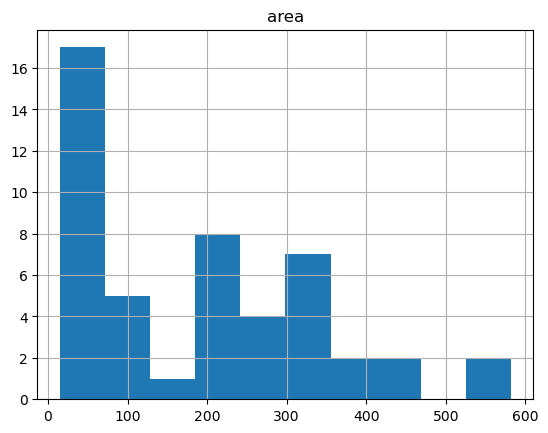

In [22]:
df_cellpose.hist(column='area')